In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/samples/0782492000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")

writer = pd.ExcelWriter('output1.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')
writer.save()

data


,0,1,2,3,4
0,490-98-8332,Joshua,,Claus,_ $147 64
1,334-74-9882,Tony,,Colona,"$1,181 12"
2,491-96-3738 —,Joshua ~,,Davis,"$2,878 98"
3,497-92-7656,Donald,,Dixon,$315 28
4,490-76-9890 _,John,,Duello,"$10,843 20"
5,491-82-6337,Steve,,Fischer,"_ $1,162 67."
6,498-90-7571,Shannon,,Freeman,"_ $3,561 82"
7,322-74-1180,Charles,,Hinterthuer,"$4,881.35"
8,493-96-3766,Brad,,House,"$4,466 11"
9,500-13-2520 |,Easton,,House _,"$1,173 12"


In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/0890280000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output2.xlsx', engine='xlsxwriter') 
writer = pd.ExcelWriter('output2.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')
writer.save()

data



,0,1,2,3,4
0,,"Print employer's name and account number as shown on Form MODES-4 Quarterly Contribution and Wage Report 08-90280-0-00 T-N-T North Glenstone, LLC 620 W Republic Rd Ste 104 Springfield MO 65807",,,CALENDAR QUARTER AND YEAR 1st X 2nd 3rd 4th Year 2020
1,16 Soc Sec No,,17 First name Middle Inttlal,Last name,Probationary End date Probatlonary Start Date 20 Probe- tlonary 18 Total Wages | 419 Mulltl- State
2,487-92-3187,,__ Leonna—,Risner,"4,401 30"
3,| 499-17-6686,,Geneca _,Roberts,213 38
4,| 500-13-8322,,Brooke _,Rovito,"5,266 73"
5,486-13-86910,,Hokoem |,Seay,"2,846 06"
6,461-87-2412,,Anthony _,Sea,"1,483 26"
7,490-15-4744,,Austin,Skidmore,748 89
8,498-13-0596,,Adam,Slavons,"3,722 10"
9,492-111-4193,,Brynn,Smith |,"2,544 76"


In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/0113647000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output3.xlsx', engine='xlsxwriter') 
writer = pd.ExcelWriter('output3.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')
writer.save()

data



,0,1,2
0,,,
1,,2 MO EMPLOYER ACCOUNT NO 01-13647-0-00 |,AUDIT | (DO NOT | _ USE) YEAR 2020
2,,,qlysfz De] mf] Po] »
3,,,"MUST HAVE AMOUNTS IN 4, 5, & 6, EVEN IF ZERO"
4,,4 TOTAL WAGES PAID,"we 361,284 49"
5,,"'§ WAGES PAID IN EXCESS OF 11,500 00 PER WORKER PER YEAR (See Instruction Sheet)","5,560 00"
6,,6 TAXABLE WAGES (Item 4 Minus Item 5),"355,724 49"
7,,7 TAXES DUE (Multiply Item 6 by Your Rate) 1 0560,"3,756 45"
8,"If mailing, return this page with remittance to Division of Employment Security P.O. Box 888 Jefferson City, MO 65102-0888 | Make check payable to Division of Employment Security | or pay online at winteract,| labor.mo 0.20 GREATER OF 10% OR $100 PENALTY AFTER 05/31/20 GREATER OF 20% OR $200 PENALTY AFTER 06/30/20 Place Xin applicable box and aoe ‘Employer Change Request ” [| Business Employment Change of Sold _ |_| oe | Address If mailing, return this page with remittance to Division of Employment Security P.O. Box 888 Jefferson City, MO 65102-0888 Make check payable to Division of Employment Security or pay online at winteract, labor mo.gov",8 INTEREST ASSESSMENT DUE TO FEDERAL ADVANCES 9 INTEREST CHARGES OF PER MONTH IF PAID AFTER 04/30/20,
9,,10 LATE REPORT PENALTY CHARGES (See [tem 15 to the Left),


In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/0121023000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output4.xlsx', engine='xlsxwriter') 
writer = pd.ExcelWriter('output4.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')
writer.save()

data



,0,1,2
0,,,
1,,,
2,Middle Initial First Initlal 18 Social Security Number,17 Worker Name {Last Name),18 Total Wages Paid This Quarter 18 Probationary
3,4267 29 483,CAMPBELL,"$2,481 80 eee ANIMAS"
4,86 2033 487,VALENTINE,"——— a) $5,817 33"
5,0 878 490,FINDLING,"$2,087 25"
6,3650 487,JOHNSON,"$5,059 56"
7,2719 96 268,ISTOTT,"$4,074 21"
8,6615 491,WATSON,"$10,084 91"
9,6642 490,WATSON,"$7,343 69"


In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output4.xlsx', engine='xlsxwriter') 
#writer = pd.ExcelWriter('output4.xlsx', engine='xlsxwriter')
#data.to_excel(writer, sheet_name='Sheet1')
#writer.save()

data



,0,1,2
0,,,


In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/0298801000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output4.xlsx', engine='xlsxwriter') 
#writer = pd.ExcelWriter('output4.xlsx', engine='xlsxwriter')
#data.to_excel(writer, sheet_name='Sheet1')
#writer.save()

data



,0,1
0,,
1,i SS a -—,
2,,
3,,
4,,
5,,
6,,
7,,
8,,
9,,


In [6]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/0621200000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output4.xlsx', engine='xlsxwriter') 
#writer = pd.ExcelWriter('output4.xlsx', engine='xlsxwriter')
#data.to_excel(writer, sheet_name='Sheet1')
#writer.save()

data



,0,1
0,,18 Total Wages Paid this Quarter


In [7]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/0134407000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output4.xlsx', engine='xlsxwriter') 
#writer = pd.ExcelWriter('output4.xlsx', engine='xlsxwriter')
#data.to_excel(writer, sheet_name='Sheet1')
#writer.save()

data



,0,1
0,,
1,,
2,,
3,,—S
4,,
5,,
6,,
7,,
8,,
9,,


In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/table_extracted/0890280000/table-000.png'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="left")


#data.to_excel('output4.xlsx', engine='xlsxwriter') 
#writer = pd.ExcelWriter('output4.xlsx', engine='xlsxwriter')
#data.to_excel(writer, sheet_name='Sheet1')
#writer.save()

data



,0,1
0,,"CALENDAR QUARTER AND YEAR 1st X 2nd 3rd 4th Year 2020 Print employer's name and account number as shown on Form MODES-4 Quarterly Contribution and Wage Report 08-90280-0-00 T-N-T North Glenstone, LLC 620 W Republic Rd Ste 104 Springfield MO 65807"
1,16 Soc Sec No,Probationary End date Probatlonary Start Date Last name 17 First name Middle Inttlal 20 Probe- tlonary 18 Total Wages | 419 Mulltl- State
2,487-92-3187,"Risner __ Leonna— 4,401 30"
3,| 499-17-6686,Roberts Geneca _ 213 38
4,| 500-13-8322,"5,266 73 Rovito Brooke _"
5,486-13-86910,"Seay Hokoem | 2,846 06"
6,461-87-2412,"Anthony _ 1,483 26 Sea"
7,490-15-4744,748 89 Skidmore Austin
8,498-13-0596,"3,722 10 Slavons Adam"
9,492-111-4193,"2,544 76 Smith | Brynn"


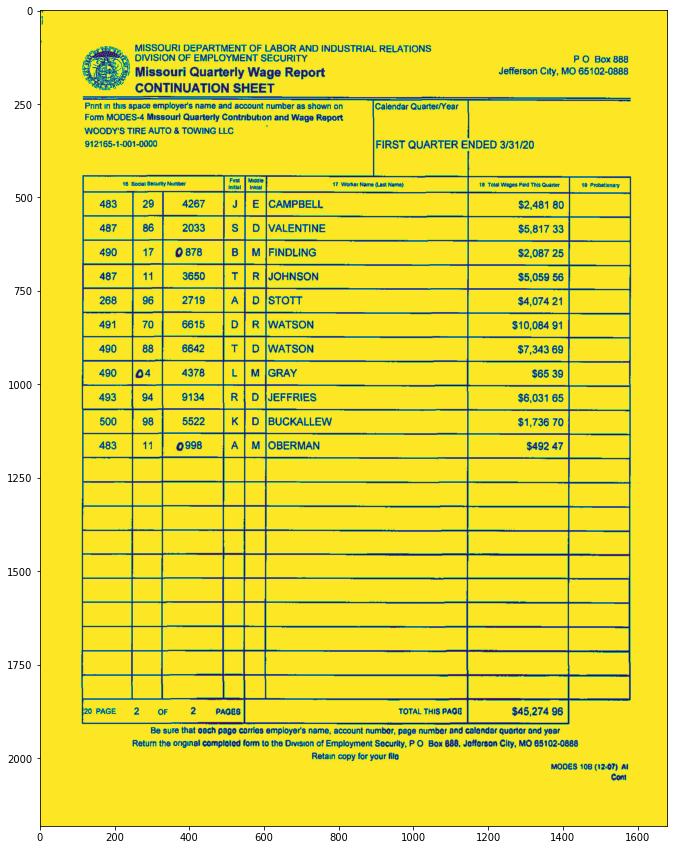

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('/home/vimal/Documents/table_detect_samples/pre/0121023000.jpeg')

plt.figure(figsize=(15,15))
# Output Images
plt.imshow(img)

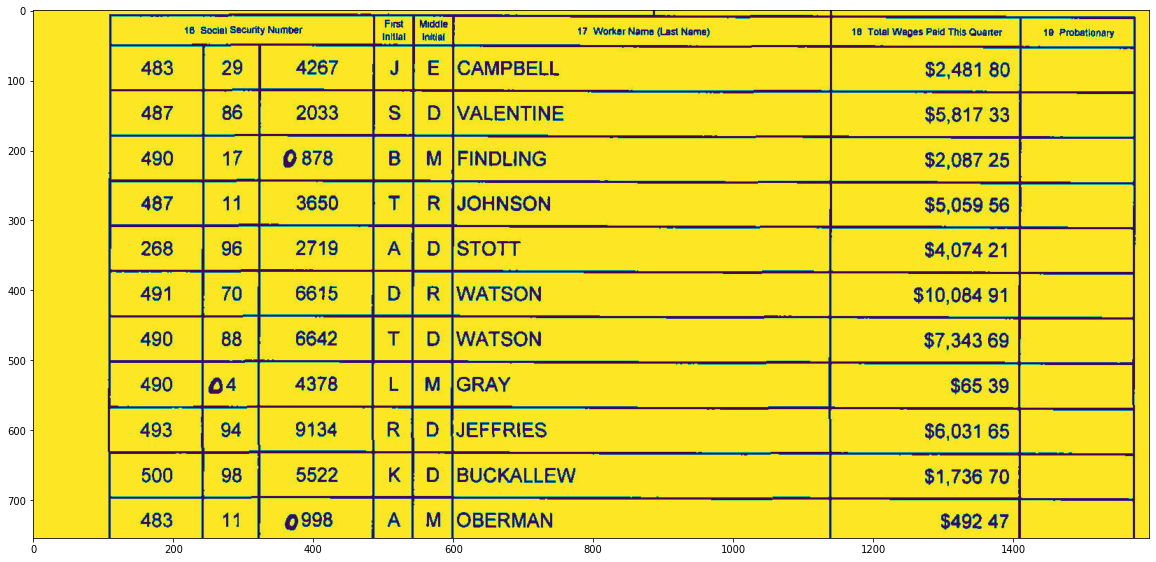

In [2]:
from PIL import Image
import cv2
  
# Opens a image in RGB mode
im = Image.open(r"/home/vimal/Documents/table_detect_samples/pre/0121023000.jpeg")
#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height /5
right = 1600
bottom = 3 * height / 5.5
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
im1.save('/home/vimal/Documents/table_detect_samples/pre/crop_images/0121023000.jpeg')
  
# Shows the image in image viewer

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/crop_images/0121023000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="right")

writer = pd.ExcelWriter('out.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')
writer.save()

data


,0,1,2,3,4,5,6,7
0,18 Social Security Number,,,First Initlal,Middle Initial,17 Worker Name {Last Name),18 Total Wages Paid This Quarter,18 Probationary
1,483,29,4267,,,CAMPBELL,"$2,481 80",
2,487,86,2033,S,,VALENTINE,"~~ ).!UUCUCOC~CS”:C~C<i*;< a $5,817 33",
3,490,,0 878,,,FINDLING,"$2,087 25",
4,487,,3650,,,JOHNSON,"$5,059 56",
5,268,96,2719,,,ISTOTT,"$4,074 21",
6,491,,6615,,,WATSON,"$10,084 91",
7,490,88,6642,,,WATSON,"$7,343 69",
8,490,,4378,,,GRAY,$65 39,
9,493,94,9134,,,JEFFRIES,"$6,031 65",


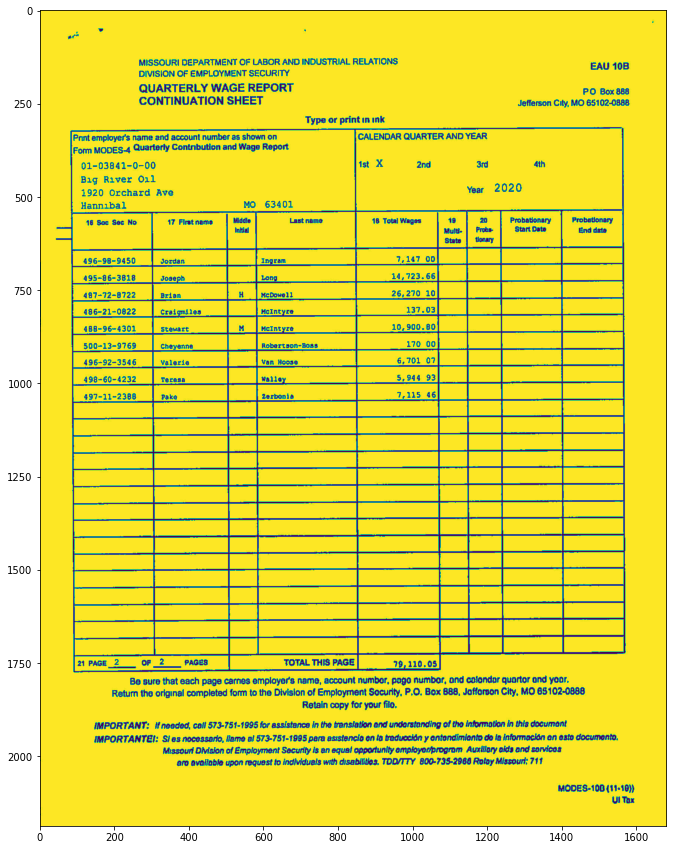

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('/home/vimal/Documents/table_detect_samples/pre/0103841000.jpeg')

plt.figure(figsize=(15,15))
# Output Images
plt.imshow(img)

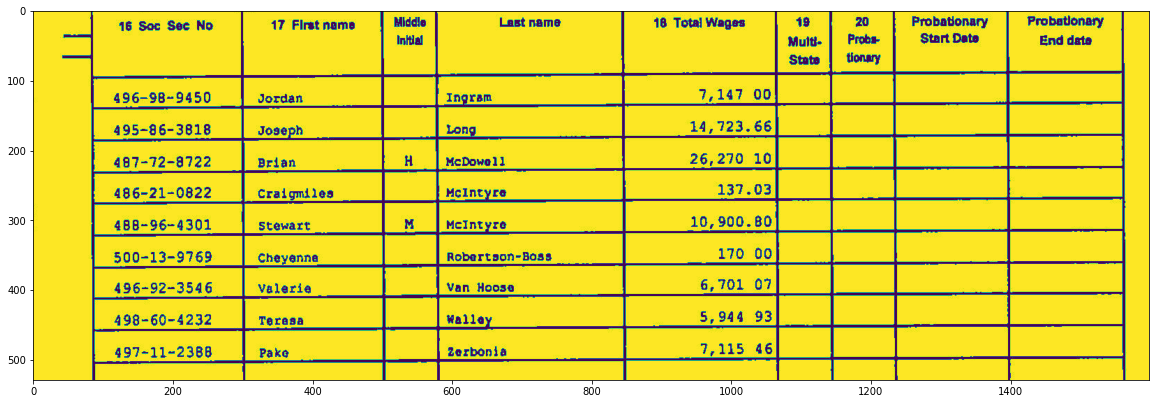

In [5]:
from PIL import Image
import cv2
  
# Opens a image in RGB mode
im = Image.open(r"/home/vimal/Documents/table_detect_samples/pre/0103841000.jpeg")
#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 1
top = height /4
right = 1600
bottom = 3 * height / 6.1
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
im1.save('/home/vimal/Documents/table_detect_samples/pre/crop_images/0103841000.jpeg')
  
# Shows the image in image viewer

In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/crop_images/0103841000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="right")

writer = pd.ExcelWriter('out1.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')
writer.save()

data


,0,1,2,3,4,5,6,7,8
0,16 Soc Sec No,17 Firet name,Middle Initial,Last name,18 Total Wages,"19 Multi- Stato ,",Probs- tionary,Probationary Start Date,Probationary End date
1,496-98-9450,Jordan,,Ingram,"7,147 00:",,,,&
2,495-86-3818,Joseph,,Long,"14,723.66",,,,
3,487-72-8722,Brian,,McDowell,"26,270 10",,,,
4,486-21-0822,_ Craigmiles _,,McIntyre,137.03,,,,
5,48B-96-4301,Stewart _,,McIntyre,"10,900.80'",,,,
6,500-13-9769,Cheyenna,,Rebertson-Boss >,170 00.,,teeth,,
7,496-92-3546,Valeria |,,Van Hoose,"6,701 07",,,,
8,_ 498-60-4232,Teresa,,Walley,"5,944 93",,,,
9,497~11~2388,Pake,Reet,Zerbonia,"_ 7,115 46",,,,


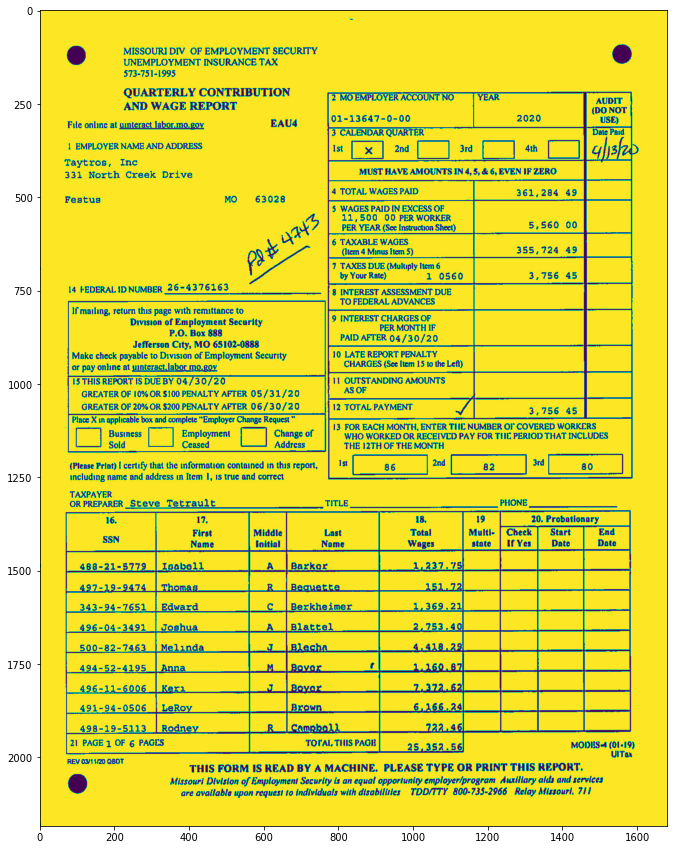

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('/home/vimal/Documents/table_detect_samples/pre/0113647000.jpeg')

plt.figure(figsize=(15,15))
# Output Images
plt.imshow(img)

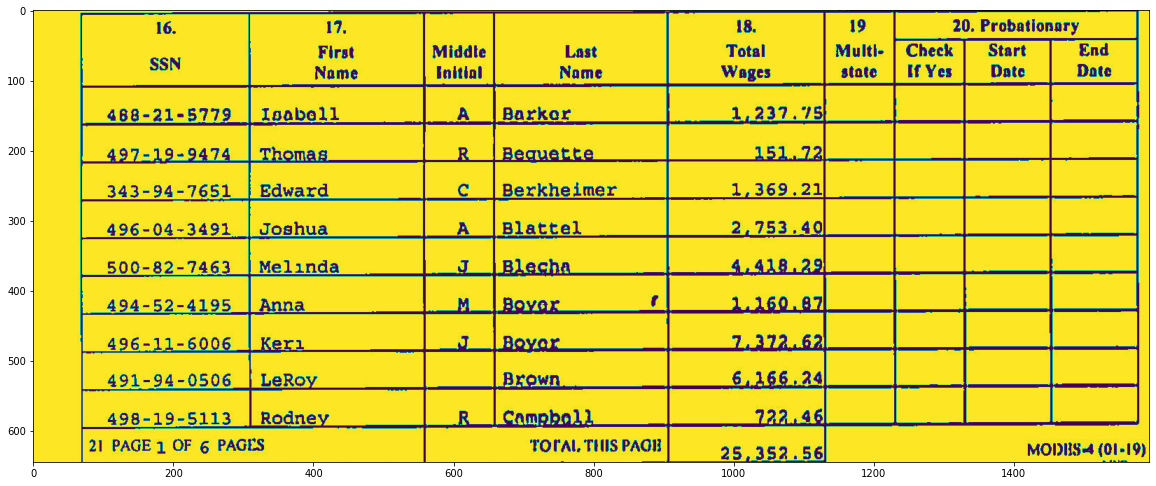

In [8]:
from PIL import Image
import cv2
  
# Opens a image in RGB mode
im = Image.open(r"/home/vimal/Documents/table_detect_samples/pre/0113647000.jpeg")
#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left =1
top = height /1.63
right = 1595
bottom = 3 * height / 3.3
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
im1.save('/home/vimal/Documents/table_detect_samples/pre/crop_images/0113647000.jpeg')
  
# Shows the image in image viewer

In [10]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/home/vimal/Documents/table_detect_samples/pre/crop_images/0113647000.jpeg'
img = cv2.imread(file,0)
img.shape

thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
img_bin = 255-img_bin
#cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)

bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
#plotting = plt.imshow(image,cmap='gray')
#plt.show()

row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
#print(column)
#print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
    
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)
            
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
#print(dataframe)

data = dataframe.style.set_properties(align="right")
df = data.data


writer = pd.ExcelWriter('out2.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')
writer.save()

data


,0,1,2
0,First Name SSN,Last _ Name Middle Knitial,__20. Probationary 19 Multl- state Total Wages
1,,,End Date Start Date Check If Yes |
2,Isabell 468-21-5779 |,,"1,237.75"
3,Thomas 497-19-9474,Beauette,enti. 151.72
4,Edward 343-94-7651,Berkheimer,"1,369.21"
5,Joshua 496-04-3491 _,Blattel,"2,753.49"
6,Melinda §00-82-7463,i\Blecha,"4,418.29"
7,Anna __494-52-4195,Bover,1.160.87
8,Keri 496-11-6006 __,Bover,"7,372.62"
9,| Le@Roy 491-94-0506,Brown.,"6,166,24"


In [9]:
type(df)

pandas.core.frame.DataFrame

In [3]:
df = data.data



In [4]:
df

,0,1,2
0,First\nName\n SSN\n,Last\n_ Name\n Middle\nKnitial\n,__20. Probationary\n 19\nMultl-\nstate\n To...
1,,,End\nDate\n Start\nDate\n Check\nIf Yes |\n
2,Isabell\n 468-21-5779 |\n,,"1,237.75\n"
3,Thomas\n 497-19-9474\n,Beauette\n,\n\n \n\nenti.\n \n 151.72\n
4,Edward\n 343-94-7651\n,Berkheimer\n,"1,369.21\n"
5,Joshua\n 496-04-3491 _\n,Blattel\n,"2,753.49\n"
6,Melinda\n §00-82-7463\n,i\Blecha\n,"4,418.29\n"
7,Anna\n __494-52-4195\n,Bover\n,1.160.87\n
8,Keri\n 496-11-6006 __\n,Bover\n,"\n 7,372.62\n"
9,| Le@Roy\n 491-94-0506\n,Brown.\n,"\n\n6,166,24\n"


In [6]:
type(df)

pandas.core.frame.DataFrame